In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import deque

In [2]:
train_df = pd.read_csv("./AIFrenz_Season1_dataset/train.csv")
train_df.drop(columns=["X14","X16","X19"], inplace=True)
print(train_df.shape)
train_df.head()

(4752, 57)


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


In [3]:
x_10parts = np.array(train_df[train_df.columns[1:38]].iloc[:-432], dtype=np.float32)
x_18parts = np.array(train_df[train_df.columns[1:38]].iloc[-432:], dtype=np.float32)
y_10parts = np.array(train_df["Y10"].iloc[:-432], dtype=np.float32).reshape(-1)
y_18parts = np.array(train_df[train_df.columns[-1:]].iloc[-432:], dtype=np.float32).reshape(-1)
print(x_10parts.shape, x_18parts.shape, y_10parts.shape, y_18parts.shape)

(4320, 37) (432, 37) (4320,) (432,)


In [4]:
temp = x_10parts[:-144*5]
temp_mean = temp.mean(axis=0)
temp_std = temp.std(axis=0)

dq = deque(maxlen=72)
x=[]
y=[]
for idx in range(len(x_10parts)):
    dq.append(x_10parts[idx])
    if len(dq)==72:
        temp_ = np.array(dq, dtype=np.float32)
        temp_ = (temp_-temp_mean)/temp_std
        x.append(temp_)
        y.append(np.array(y_10parts[idx], dtype=np.float32))
x = np.array(x)
y = np.array(y)
print(x.shape, y.shape)

(4249, 72, 37) (4249,)


In [5]:
x_train = x[:-144*5]
x_test = x[-144*5:]
y_train = y[:-144*5]
y_test = y[-144*5:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3529, 72, 37) (3529,) (720, 72, 37) (720,)


In [6]:
x_train = x_train.reshape(-1,72,37,1)
x_test = x_test.reshape(-1,72,37,1)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3529, 72, 37, 1) (3529,) (720, 72, 37, 1) (720,)


In [7]:
def return_model():
    input_tens = tf.keras.Input(shape=(72,37,1))
    x = tf.keras.layers.Permute((2,1,3))(input_tens)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, kernel_size=6))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, kernel_size=6))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, kernel_size=6))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, kernel_size=6))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, kernel_size=6))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(16)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(1)(x)
    #x = tf.keras.layers.concatenate(inputs=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17])
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])
    print(model.summary())
    return model

In [8]:
model = return_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 37, 1)]       0         
_________________________________________________________________
permute (Permute)            (None, 37, 72, 1)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 37, 67, 64)        448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 37, 67, 64)        256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 37, 67, 64)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 37, 33, 64)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 37, 28, 64)        24640 

In [9]:
model.fit(x_train, y_train, epochs=1000, batch_size=256, validation_data=(x_test,y_test))

Train on 3529 samples, validate on 720 samples
Epoch 1/1000
3529/3529 [==============================] - 18s 5ms/sample - loss: 676.1737 - mae: 24.2125 - val_loss: 740.3311 - val_mae: 25.5207
Epoch 2/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 647.9530 - mae: 23.6616 - val_loss: 721.4421 - val_mae: 25.1830
Epoch 3/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 637.2532 - mae: 23.4465 - val_loss: 715.3950 - val_mae: 25.0705
Epoch 4/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 628.8408 - mae: 23.2755 - val_loss: 711.2796 - val_mae: 25.0100
Epoch 5/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 621.7841 - mae: 23.1406 - val_loss: 707.0891 - val_mae: 24.9464
Epoch 6/1000
3529/3529 [==============================] - 16s 5ms/sample - loss: 614.6043 - mae: 23.0015 - val_loss: 703.7114 - val_mae: 24.8846
Epoch 7/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 60

Epoch 57/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 150.9988 - mae: 11.8674 - val_loss: 226.2588 - val_mae: 14.0820
Epoch 58/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 144.4302 - mae: 11.6066 - val_loss: 222.6343 - val_mae: 13.8142
Epoch 59/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 138.3903 - mae: 11.3319 - val_loss: 206.6393 - val_mae: 13.4321
Epoch 60/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 132.4034 - mae: 11.0672 - val_loss: 220.4056 - val_mae: 13.7434
Epoch 61/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 127.1282 - mae: 10.8158 - val_loss: 204.9088 - val_mae: 13.1741
Epoch 62/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 121.2921 - mae: 10.5653 - val_loss: 198.2023 - val_mae: 12.8010
Epoch 63/1000
3529/3529 [==============================] - 17s 5ms/sample - loss: 115.7486 - mae: 10.2967 - val_loss: 184.61

3328/3529 [===========================>..] - ETA: 0s - loss: 9.8683 - mae: 2.4650

KeyboardInterrupt: 

In [ ]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
x_18parts_reg = (x_18parts-x_10parts_train_min)/(x_10parts_train_max-x_10parts_train_min)
after_pred = model.predict(x_18parts_reg)

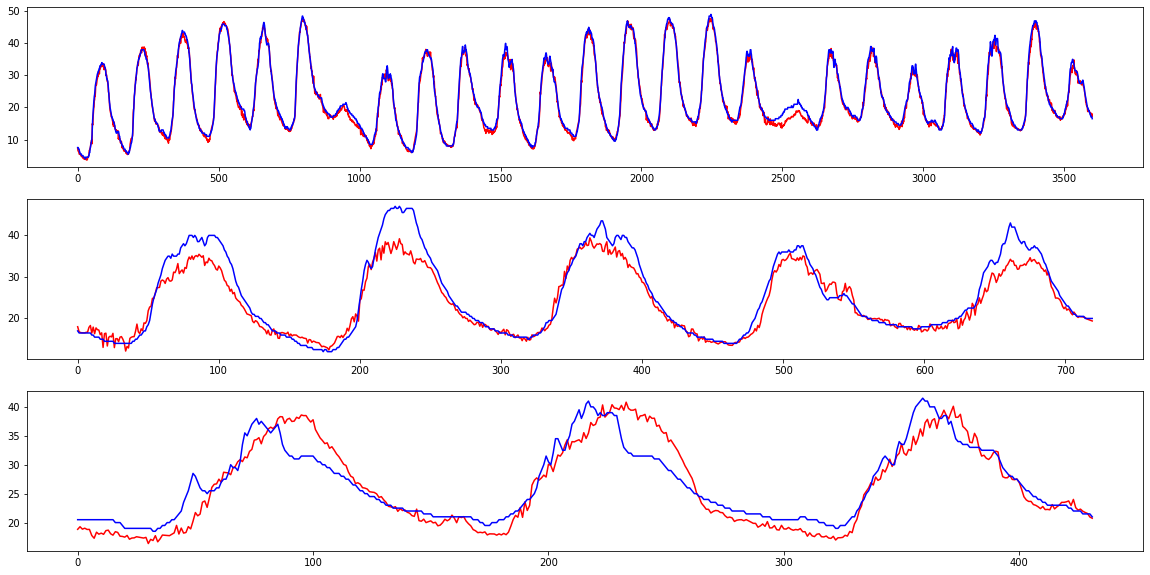

In [29]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.plot(train_pred, color="r")
ax1.plot(y_10parts_train, color="b") 

ax2.plot(test_pred, color="r")
ax2.plot(y_10parts_test, color="b") 

ax3.plot(after_pred, color="r")
ax3.plot(y_18parts, color="b") 

plt.show()